### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence. 

The ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

If I swapped the order of the labels so that present is at index 1 and absent at index 0, the model no longer converged at all, and would end up predicting 100% of the examples as belonging to the present class. 

During training, there are the same number of positive classes as absent classes. This is true of the validation set used during training too. The full unbalanced validation set contains far more absence than presence, and hence the number of false positives is much higher in the full validation set than in the balanced one. 


I can now check the effect of cleaning the dataset. 

In [44]:
# !pip install wandb
# ! pip install wandb --upgrade

In [45]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [46]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [48]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [49]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import hashlib
model_save_path = BASE_PATH / 'models'

In [60]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "interim" / "train_and_valid_set"
df_train = pd.read_pickle(train_df_path / "train_and_valid_set.pkl")

In [61]:
# df_train.sample()

# Log some hyperparameters

In [62]:
n_samples_per_class = 800
one_output_neuron = False
random_seed = None
positive_index = 0
learning_rate = 0.01

70 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
total available human labelled target tags = 4204
undefined 266459
after filtering, 0 undefined clips remain


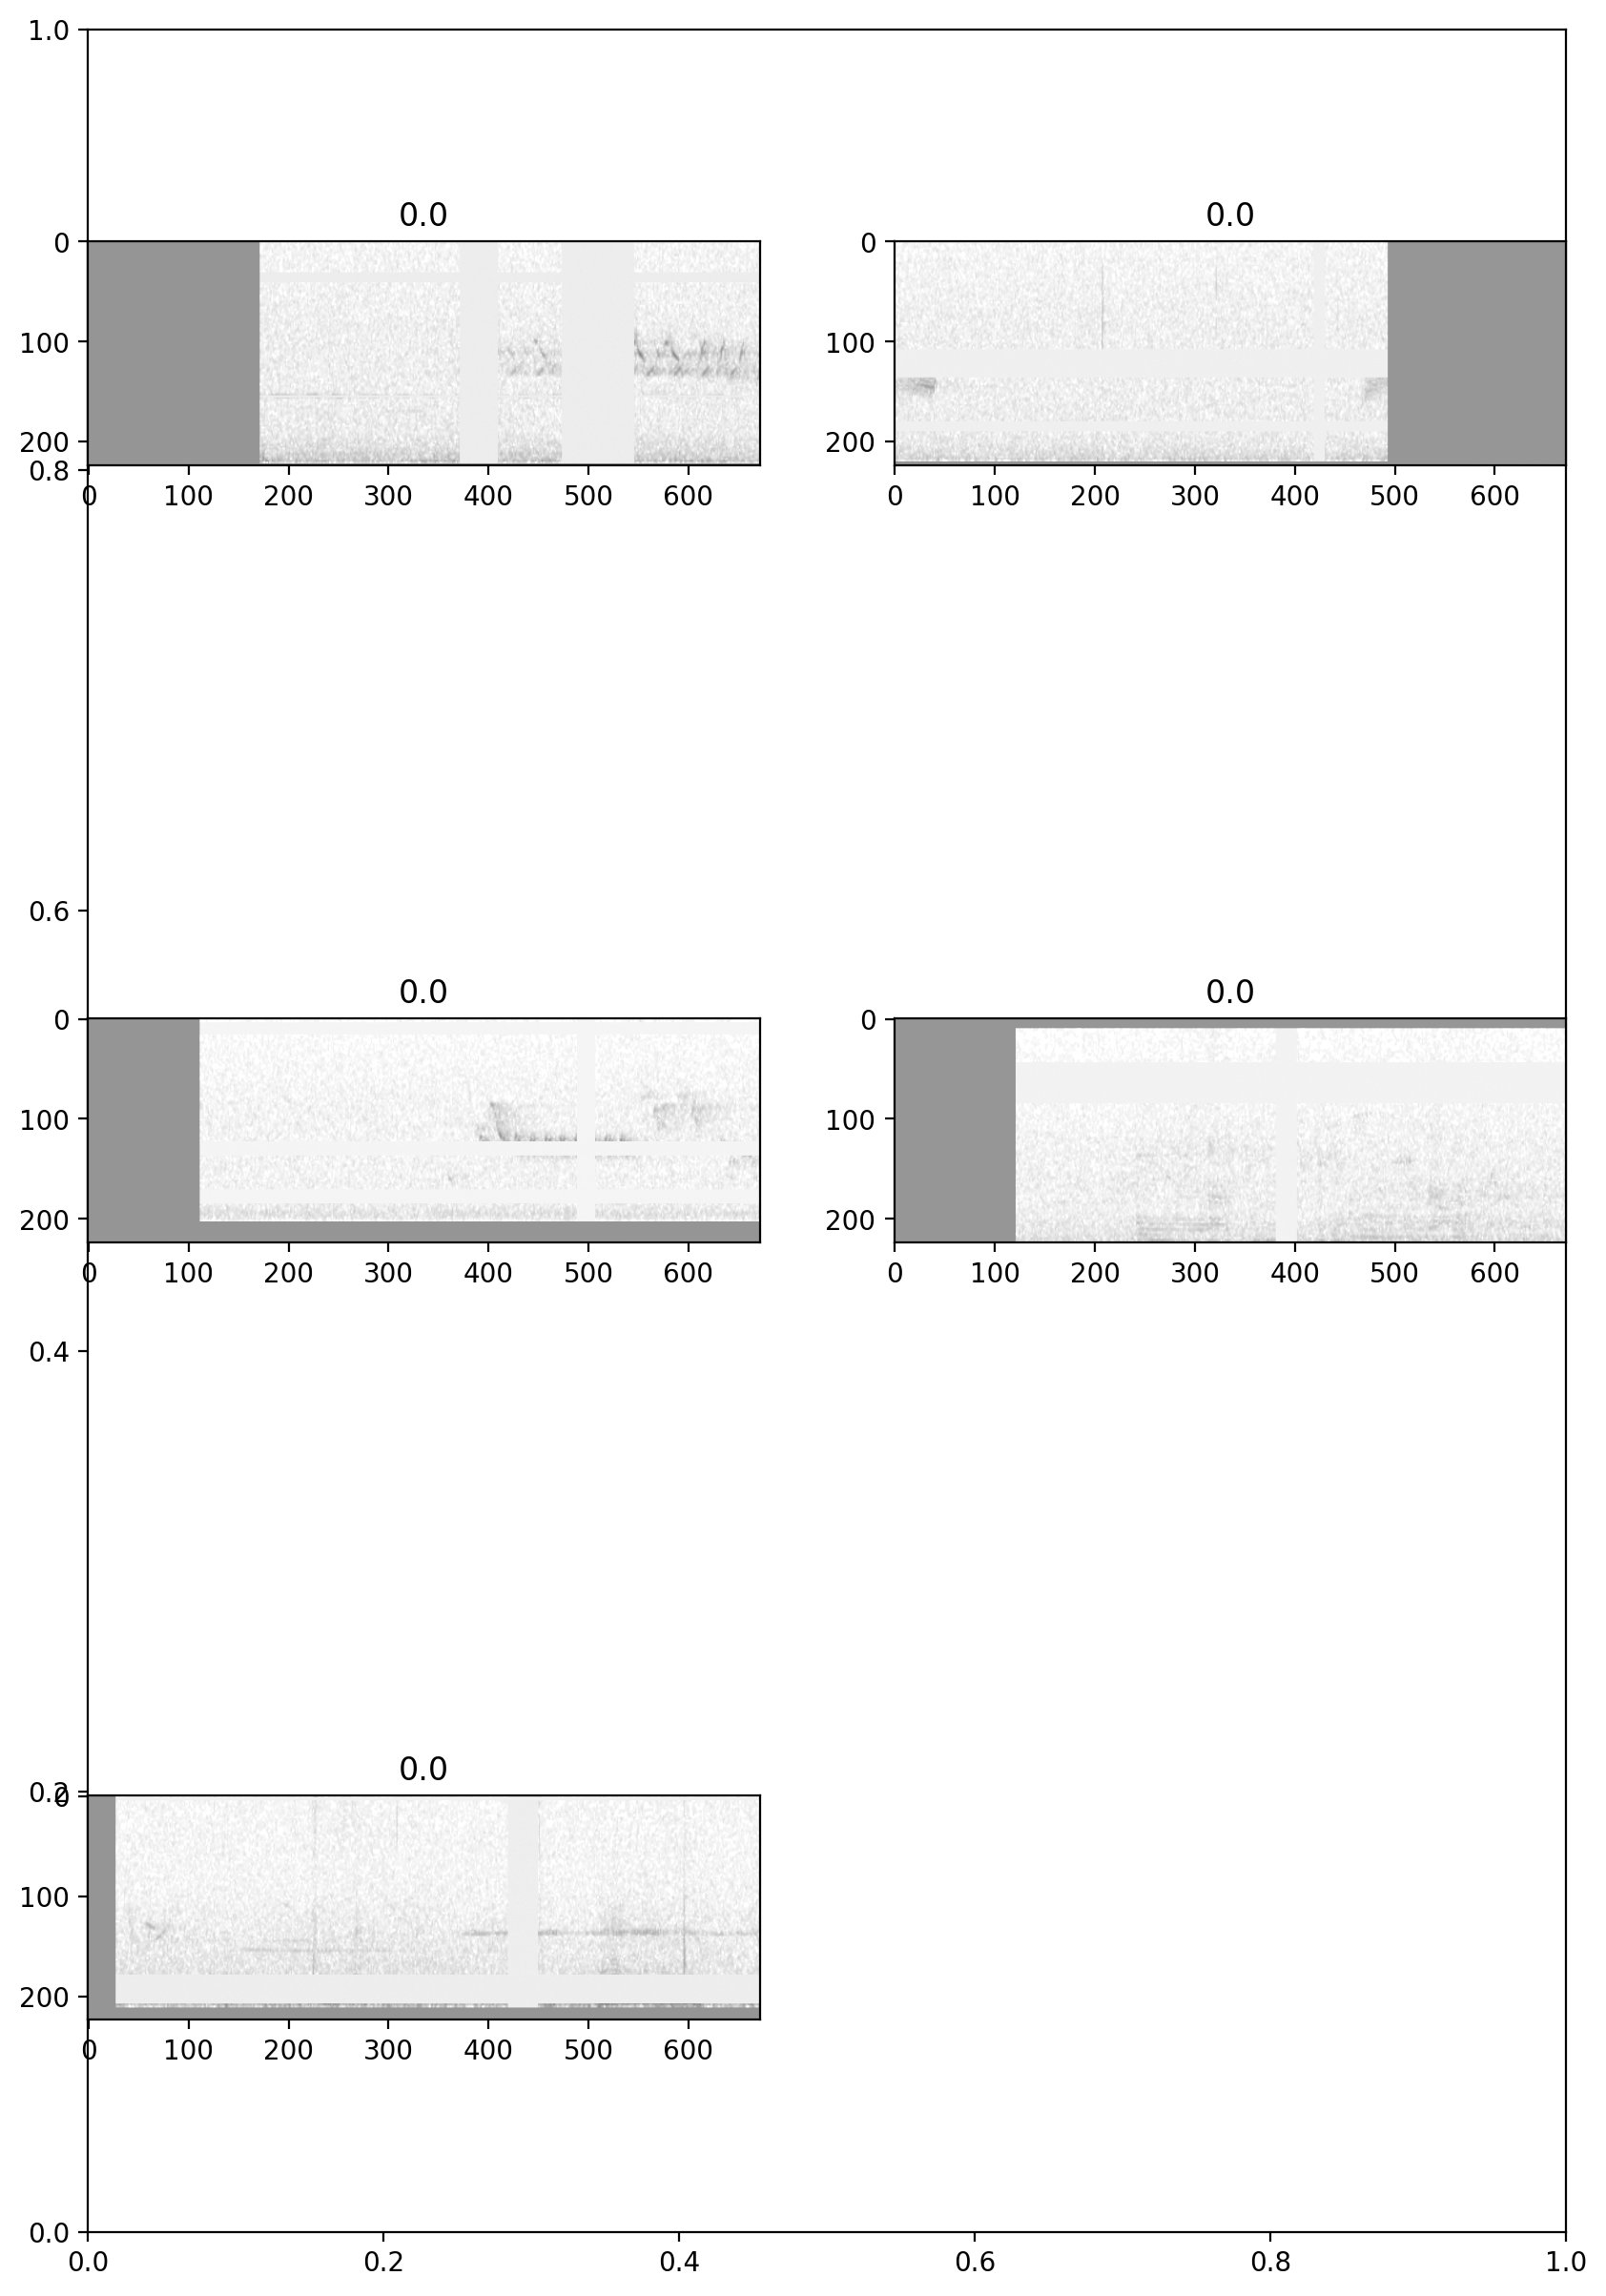

In [63]:
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0, seed=random_seed)

In [64]:
train_df = train_dataset.label_df
valid_df = valid_dataset.label_df

# train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# optionally load these from disk instead

# train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [65]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

c34008eab1713797db87b74d27429e399859910356fdb3d9660d46693e095381 0b7e0202864a1e82ac795ce2690120809396a34c3eddc77a1ac0ff1d45db1188


AssertionError: Training set has changed

In [66]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    44065
 1.0     4118
 Name: count, dtype: int64,
 target_presence
 0.0    10963
 1.0     1136
 Name: count, dtype: int64)

In [69]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

In [70]:
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 1.0    800
 0.0    800
 Name: count, dtype: int64,
 1600)

In [71]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [72]:
idx=0

In [73]:
shuffled_balanced_train_df = balanced_train_df.sample(frac = 1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac = 1)

Present label: 1.0
Last clip: 6.0
../../data/raw/recordings/OSFL/recording-294987.mp3 3.0 6.0


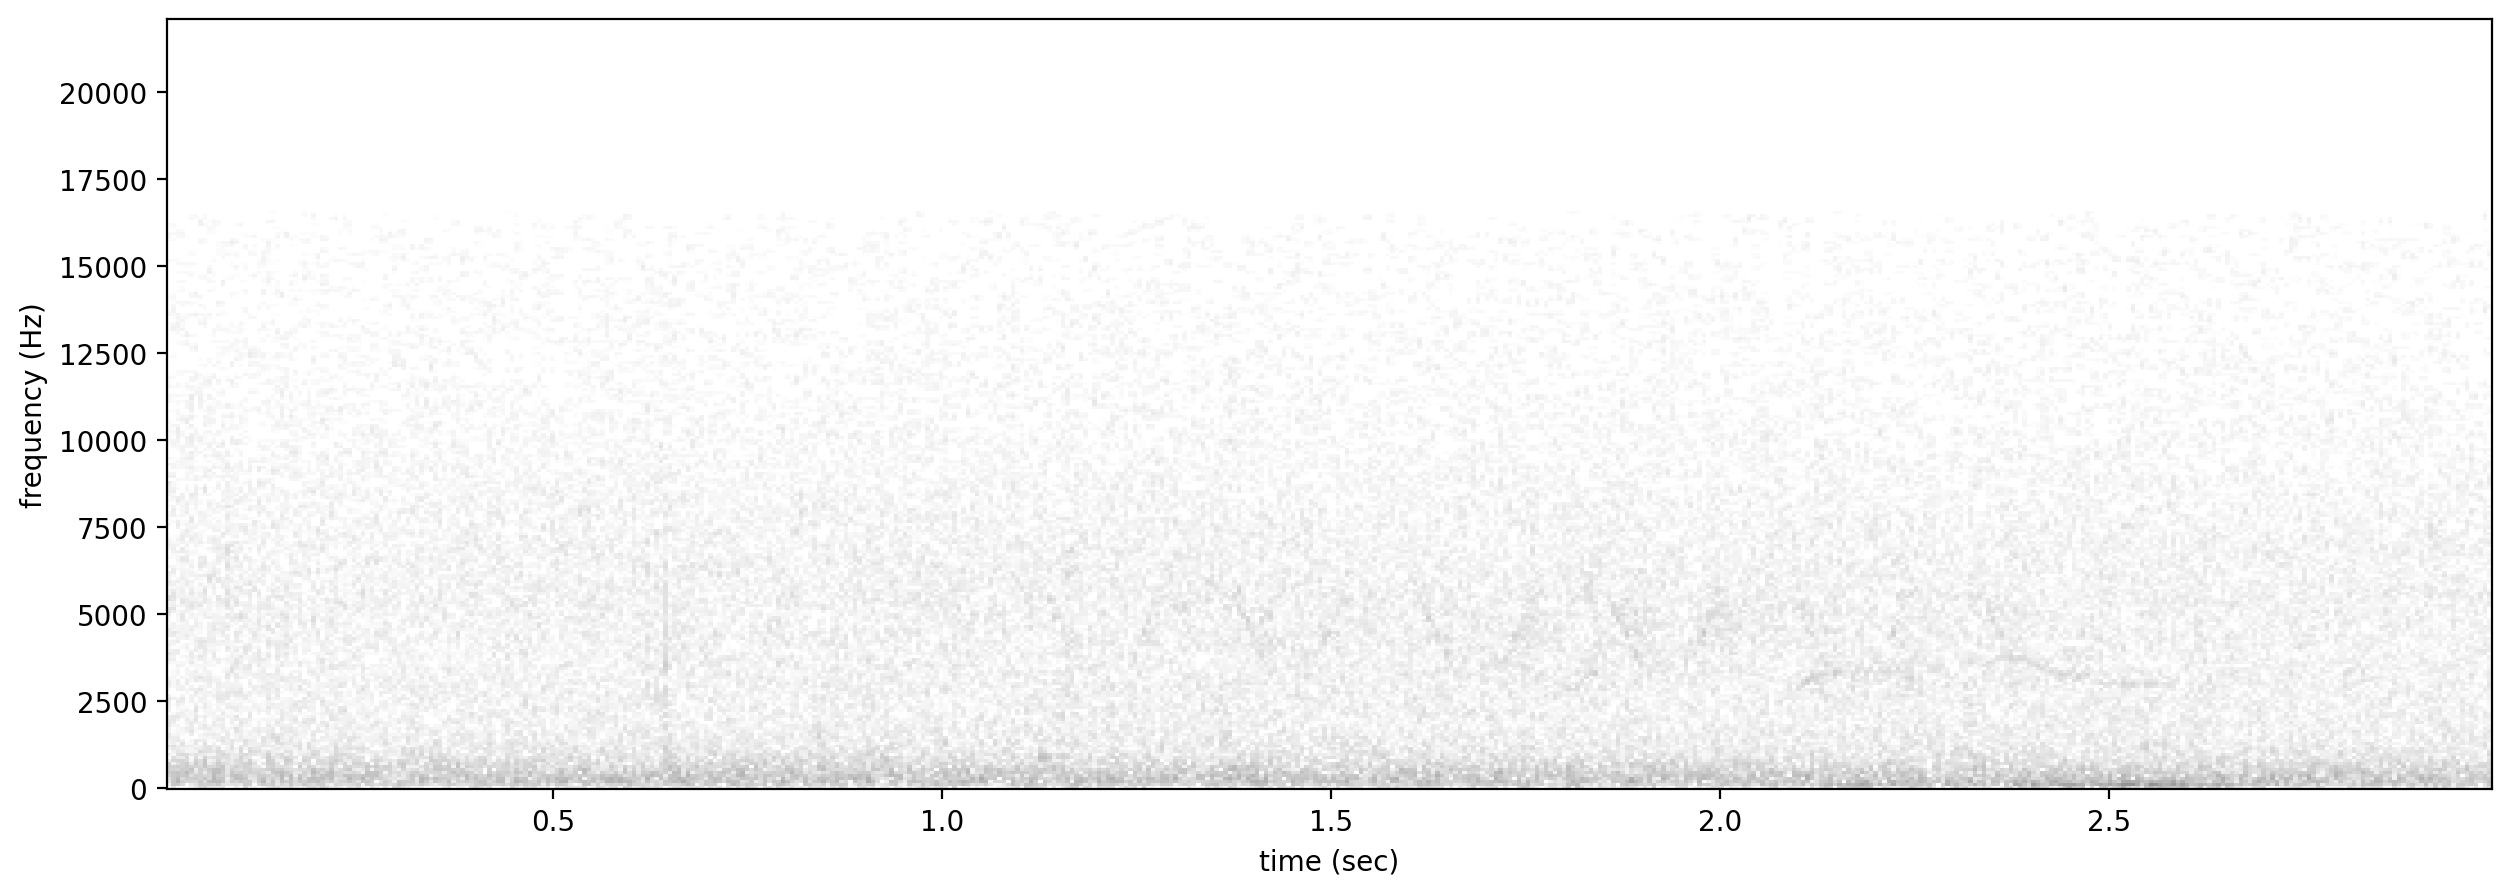

In [74]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [75]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_presence', 'target_absence'], dtype='object'),
 Index(['target_presence', 'target_absence'], dtype='object'))

In [77]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = True

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1

In [78]:
model.optimizer_params['lr'] = learning_rate


In [79]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [80]:
class_list

['target_presence', 'target_absence']

In [81]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


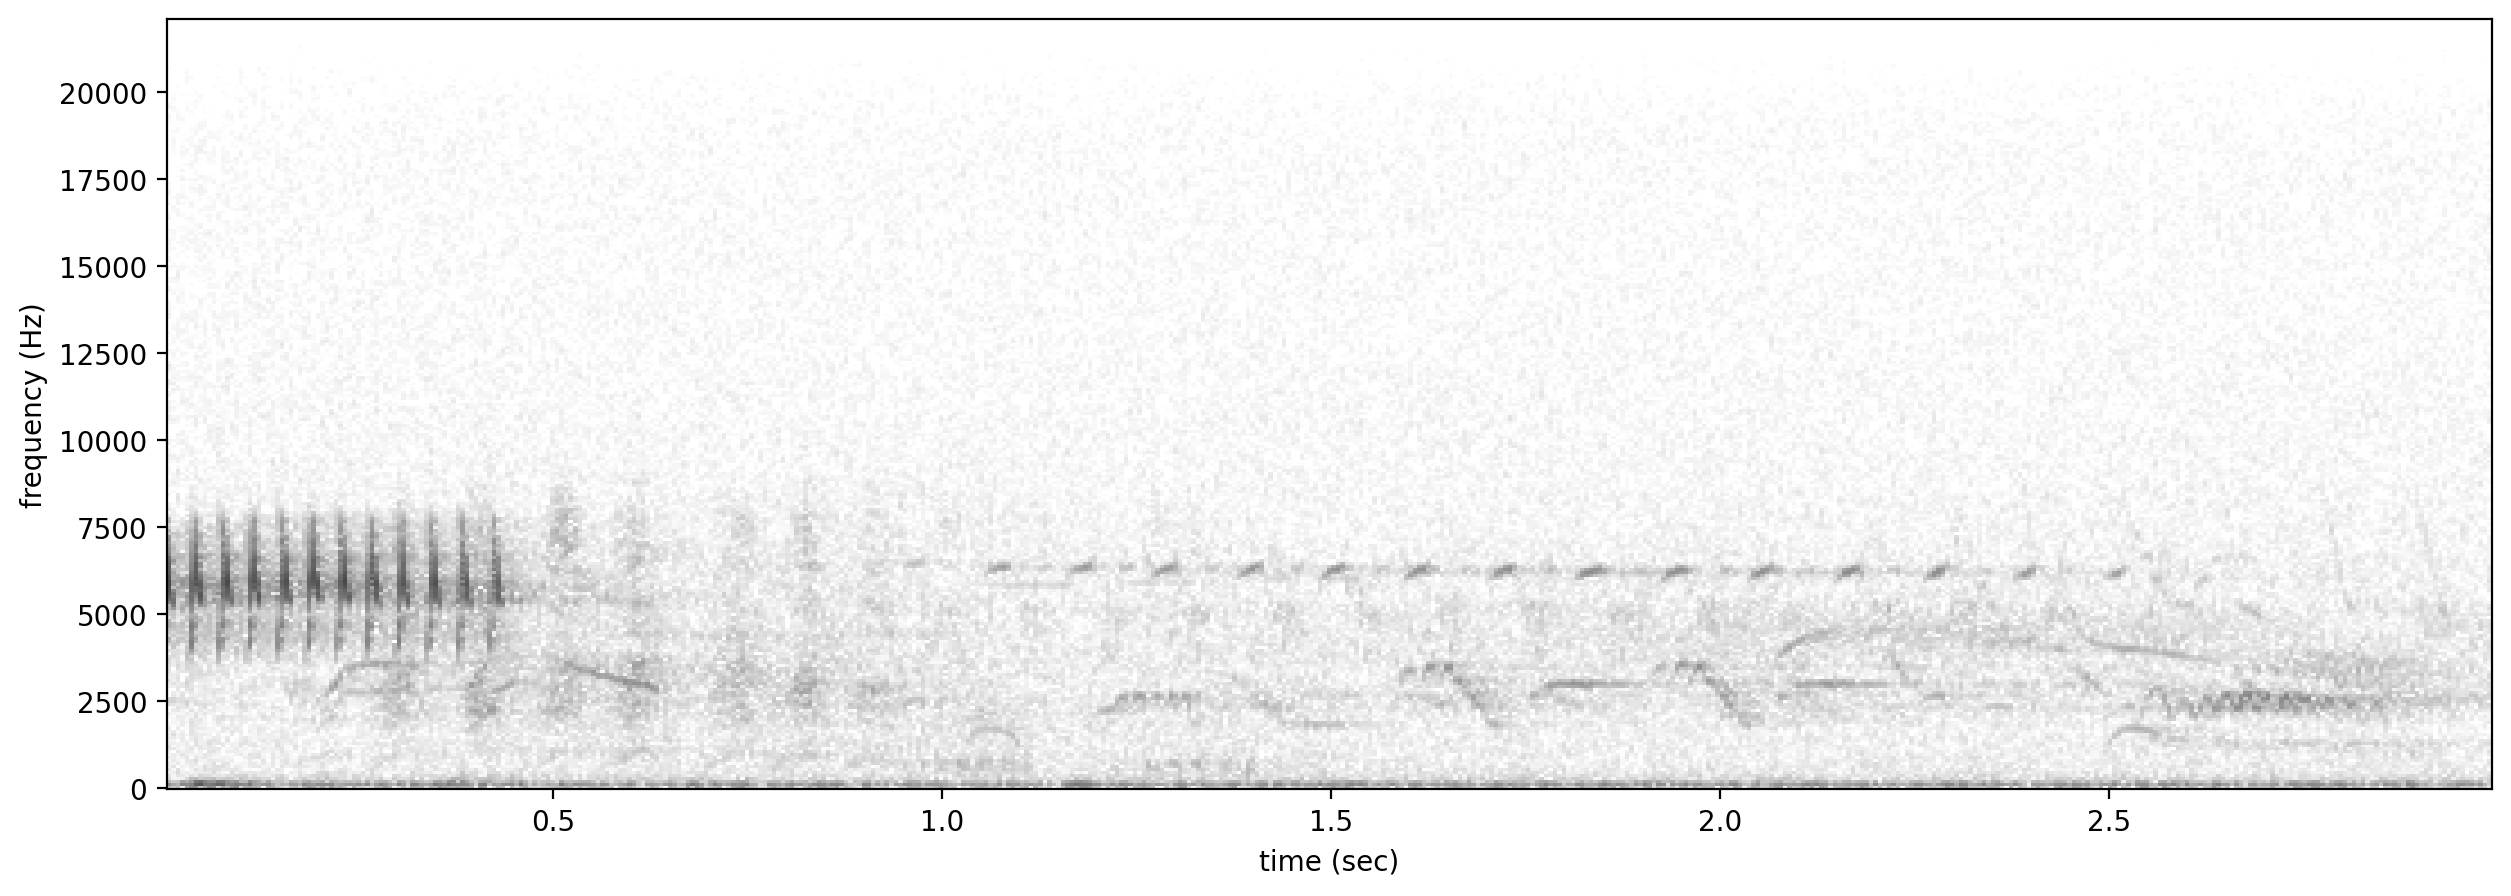

In [82]:
show_sample_from_df(present=True)

In [83]:
print(f'model.device is: {model.device}')

model.device is: mps


In [84]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [123]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    config={
    "epochs":8,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    "positive_index": positive_index,
    "balanced_valid_set": True,
    }
)


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [86]:
wandb.config.learning_rate = learning_rate

In [87]:
shuffled_balanced_valid_df.value_counts()

target_presence  target_absence
0.0              1.0               500
1.0              0.0               500
Name: count, dtype: int64

In [88]:
model.train(
    balanced_train_df,
    balanced_valid_df,
    epochs = 10,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 [batch 0/25, 0.00%] 
	DistLoss: 0.744
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 [batch 0/25, 0.00%] 
	DistLoss: 0.692
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 [batch 0/25, 0.00%] 
	DistLoss: 0.698
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 [batch 0/25, 0.00%] 
	DistLoss: 0.490
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 [batch 0/25, 0.00%] 
	DistLoss: 0.528
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 [batch 0/25, 0.00%] 
	DistLoss: 0.409
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 6


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6 [batch 0/25, 0.00%] 
	DistLoss: 0.386
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 7


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 [batch 0/25, 0.00%] 
	DistLoss: 0.305
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 8


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8 [batch 0/25, 0.00%] 
	DistLoss: 0.362
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 9


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9 [batch 0/25, 0.00%] 
	DistLoss: 0.264
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 5 with Validation score 0.881.


In [89]:
# model.train(
#     shuffled_balanced_train_df,
#     shuffled_balanced_valid_df,
#     epochs = 4,
#     batch_size = 64,
#     num_workers = 4, #4 parallelized cpu tasks for preprocessing
#     log_interval = 100,
#     save_interval = 10,
#     wandb_session = wandb_session,
#     )

In [90]:
model.valid_metrics

{0: {'confusion_matrix': array([[102, 398],
         [ 22, 478]]),
  'precision': 0.545662100456621,
  'recall': 0.956,
  'f1': 0.6947674418604651,
  'jaccard': 0.36384814274377286,
  'hamming_loss': 0.42},
 1: {'confusion_matrix': array([[416,  84],
         [162, 338]]),
  'precision': 0.8009478672985783,
  'recall': 0.676,
  'f1': 0.7331887201735359,
  'jaccard': 0.6035829574142284,
  'hamming_loss': 0.246},
 2: {'confusion_matrix': array([[479,  21],
         [289, 211]]),
  'precision': 0.9094827586206896,
  'recall': 0.422,
  'f1': 0.5765027322404371,
  'jaccard': 0.5060439974797419,
  'hamming_loss': 0.31},
 3: {'confusion_matrix': array([[478,  22],
         [273, 227]]),
  'precision': 0.9116465863453815,
  'recall': 0.454,
  'f1': 0.6061415220293725,
  'jaccard': 0.5266179437232656,
  'hamming_loss': 0.295},
 4: {'confusion_matrix': array([[469,  31],
         [170, 330]]),
  'precision': 0.9141274238227147,
  'recall': 0.66,
  'f1': 0.7665505226480837,
  'jaccard': 0.6607344

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [91]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_{dt}")

# Show metrics

In [96]:
model.valid_metrics

{0: {'confusion_matrix': array([[102, 398],
         [ 22, 478]]),
  'precision': 0.545662100456621,
  'recall': 0.956,
  'f1': 0.6947674418604651,
  'jaccard': 0.36384814274377286,
  'hamming_loss': 0.42},
 1: {'confusion_matrix': array([[416,  84],
         [162, 338]]),
  'precision': 0.8009478672985783,
  'recall': 0.676,
  'f1': 0.7331887201735359,
  'jaccard': 0.6035829574142284,
  'hamming_loss': 0.246},
 2: {'confusion_matrix': array([[479,  21],
         [289, 211]]),
  'precision': 0.9094827586206896,
  'recall': 0.422,
  'f1': 0.5765027322404371,
  'jaccard': 0.5060439974797419,
  'hamming_loss': 0.31},
 3: {'confusion_matrix': array([[478,  22],
         [273, 227]]),
  'precision': 0.9116465863453815,
  'recall': 0.454,
  'f1': 0.6061415220293725,
  'jaccard': 0.5266179437232656,
  'hamming_loss': 0.295},
 4: {'confusion_matrix': array([[469,  31],
         [170, 330]]),
  'precision': 0.9141274238227147,
  'recall': 0.66,
  'f1': 0.7665505226480837,
  'jaccard': 0.6607344

Here we can see how the opso resample operation leaves the dataframe sorted into classes, so suffling is a necessary next step. 

In [114]:
pd.concat([balanced_train_df.tail(), balanced_train_df.head()])

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-291555.mp3,64.5,67.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-295489.mp3,0.0,3.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-291743.mp3,10.5,13.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-103765.mp3,25.5,28.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-100121.flac,3.0,6.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-322587.flac,4.5,7.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-296782.mp3,10.5,13.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-538666.flac,0.0,3.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-255457.mp3,55.5,58.5,1.0,0.0


In [115]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

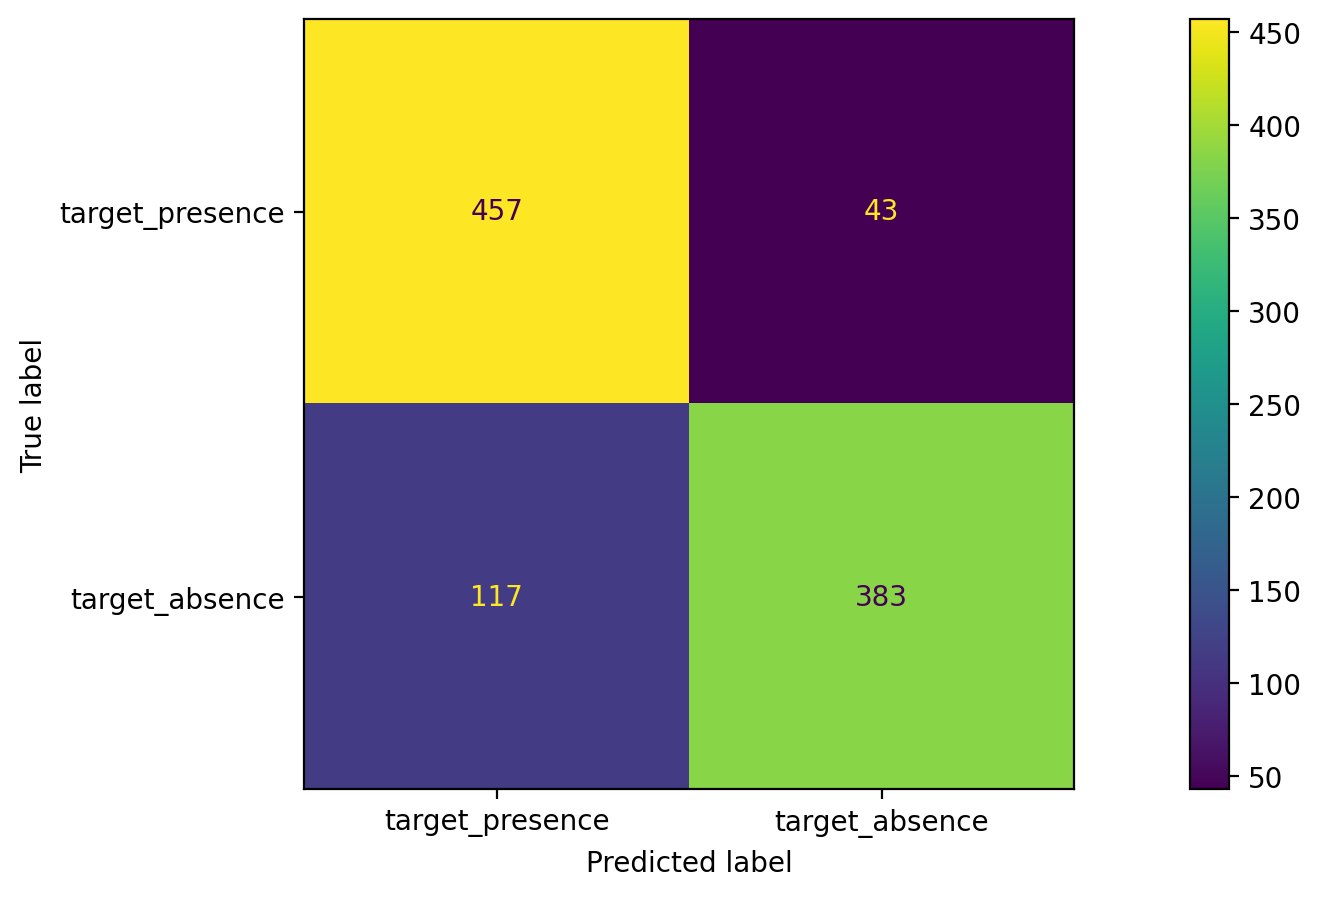

In [155]:
shuf_preds = model.predict(shuffled_balanced_valid_df)
opso.metrics.single_target_metrics(shuffled_balanced_valid_df, shuf_preds)
cm = opso.metrics.M.confusion_matrix(np.argmax(shuffled_balanced_valid_df, 1), (np.argmax(shuf_preds, 1)))
opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=model.classes).plot()

This is starting to look ok but false positives are way too high. 


# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

  0%|          | 0/12099 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


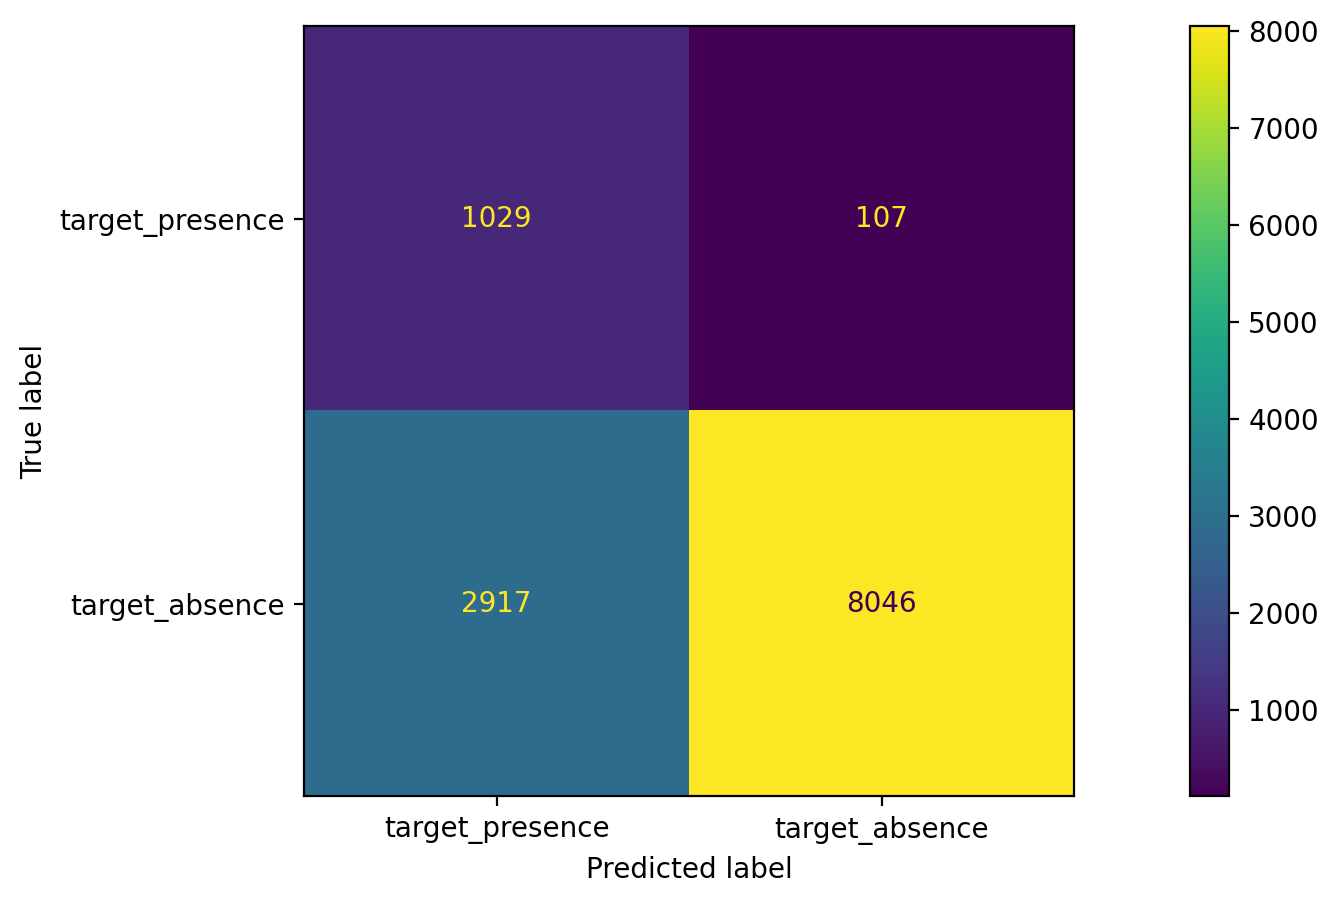

In [156]:
shuf_preds = model.predict(valid_df)
opso.metrics.single_target_metrics(valid_df, shuf_preds)
cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(shuf_preds, 1)))
opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=model.classes).plot()

In [104]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▃▂▂▁▁
epoch,9
loss,0.36056
